# IBM Data Science Capstone Project
## Week 5. Battle of the Neighbourhoods - Vancouver Neighbourhoods Analysis

In this notebook I will analyze Vancouver neighbourhoods on their average rental prices and social environments these neighbourhoods provide for their habitants. Specifically I will go through following steps:

1. Identify list of Vancouver neighbourhoods and obtain average rent prices for these neighbourhoods
2. Get neighbourhood coordinates and map neighbourhoods to have visual understanding of the region
3. Cluster neighbourhoods based on average rent prices and conduct preliminary analysis
4. Gather information on venues for each of the neighbourhoods
5. Analyze venues in the neighbourhoods by identifying the most common venue categories in each of the neighbourhoods to understand how they differentiate between each other
6. Cluster neighbourhoods based on new venues dataset
7. Analyze if social environment (venues) of the neighbourhoods impact on rent prices, and if yes, then which venue categories specifically have most effect

#### 1. Identify list of Vancouver neighbourhoods and obtain average rent prices for these neighbourhoods
First we start by importing all necessary libraries and dependencies and then by loading data from a csv file.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

!conda install -c conda-forge BeautifulSoup4 --yes
from bs4 import BeautifulSoup # library to parse HTML and XML documents

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

!conda install -c conda-forge geocoder --yes
import geocoder # import geocoder

!pip install wikipedia
import wikipedia as wp

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    numpy-1.18.1               |   py36h95a1406_0         5.2 MB  conda-forge
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    sci

In [80]:
# load data from a csv file
df = pd.read_csv("vancouver_rentals.csv", error_bad_lines=False, encoding='latin1')
df.head()

,Unnamed: 0,Vacancy Rate (%),Unnamed: 2,Availability Rate (%),Unnamed: 4,Average Rent ($),Unnamed: 6,Median Rent ($),Unnamed: 8,% Change,Unnamed: 10,Units,Unnamed: 12
0,West End/Stanley Park,0.5,a,**,NaN,"1,615",a,"1,588",a,5.4,b,"3,872",NaN
1,English Bay,0.7,a,**,NaN,"1,701",a,"1,730",a,5.4,c,"6,624",NaN
2,Downtown,1.4,a,**,NaN,"1,738",a,"1,650",a,4.5,b,"11,023",NaN
3,South Granville/Oak,0.5,a,**,NaN,"1,545",a,"1,500",a,2.7,b,"7,901",NaN
4,Kitsilano/Point Grey,0.6,a,**,NaN,"1,662",a,"1,600",a,5.5,c,"7,346",NaN


Now we need to remove all unnecessary columns and do some formatting on the dataframe to make it more suitable for further analysis.

In [81]:
# let's now remove all unnecessary columns and leave only borough names and average rent prices
df = df[['Unnamed: 0', 'Average Rent ($)']]
df.head()

,Unnamed: 0,Average Rent ($)
0,West End/Stanley Park,"1,615"
1,English Bay,"1,701"
2,Downtown,"1,738"
3,South Granville/Oak,"1,545"
4,Kitsilano/Point Grey,"1,662"


Let's now rename "Unnamed: 0" and "Average Rent ($)" columns.

In [82]:
df = df.rename(columns={"Unnamed: 0": "Neighbourhood", "Average Rent ($)": "Average_Rent"})
df.head()

,Neighbourhood,Average_Rent
0,West End/Stanley Park,"1,615"
1,English Bay,"1,701"
2,Downtown,"1,738"
3,South Granville/Oak,"1,545"
4,Kitsilano/Point Grey,"1,662"


Now I will reformat the data in "Average_Rent" column by removing the commas.

In [83]:
df['Average_Rent'] = df['Average_Rent'].str.replace(r'\D', '')
df.head()

,Neighbourhood,Average_Rent
0,West End/Stanley Park,1615
1,English Bay,1701
2,Downtown,1738
3,South Granville/Oak,1545
4,Kitsilano/Point Grey,1662


I will now change "Average_Rent" column dtype from object to int64.

In [84]:
df['Average_Rent'] = pd.to_numeric(df['Average_Rent'])
df.dtypes

Neighbourhood    object
Average_Rent      int64
dtype: object

Let's sort our dataframe by average rent price and look at the full list of neighbourhoods and associated average rent prices.

In [85]:
df = df.sort_values(by=['Average_Rent'], ascending=False)
# reset the index for consistency and further work with our dataframe
df = df.reset_index(drop=True)
df

,Neighbourhood,Average_Rent
0,University Endowment Lands,2097
1,West Vancouver,2024
2,North Vancouver DM,1881
3,Westside/Kerrisdale,1773
4,Downtown,1738
5,English Bay,1701
6,Kitsilano/Point Grey,1662
7,West End/Stanley Park,1615
8,South Granville/Oak,1545
9,Southeast Vancouver,1539


#### 2. Get neighbourhood coordinates and map neighbourhoods to have visual understanding of the region
Now, as we have gathered the list of neighbourhoods and their average rent prices, we can proceed by obtaining geographical cooodinates for the these neighbourhoods. We will use Geocoder library to obtain this information.

First, let's define a function to gather the coordinates for our neighbourhoods.

In [86]:
# define a function to get coordinates
def get_latlng(neighbourhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Vancouver, BC'.format(neighbourhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

Now we will call the function to get the coordinates and store them in a list object

In [87]:
coords = [ get_latlng(neighbourhood) for neighbourhood in df["Neighbourhood"].tolist() ]
coords

[[49.25857000000008, -123.22014999999999],
 [49.26114904019019, -123.25304149399976],
 [49.32108000000005, -123.07520999999997],
 [49.22097000000008, -123.15072999999995],
 [49.28108000000003, -123.11589999999995],
 [49.132837756669176, -122.85958479339024],
 [49.26833000000005, -123.16541999999998],
 [49.301060000000064, -123.13572999999997],
 [49.260830000000055, -123.14099999999996],
 [49.270110000000045, -123.11009999999999],
 [49.260380000000055, -123.11335999999994],
 [49.32108000000005, -123.07520999999997],
 [49.30307749685801, -123.03149972143655],
 [49.11325200000002, -122.6573235],
 [49.284611430428384, -123.13987960274116],
 [49.261780000000044, -123.09607999999997],
 [49.260380000000055, -123.11335999999994],
 [49.22665997446484, -123.00526998889144],
 [49.281163365132755, -123.09076033725671],
 [49.20706000000007, -122.90840999999995],
 [49.20067000000006, -123.13052999999996],
 [49.02392000000003, -122.79678999999999],
 [49.284611430428384, -123.13987960274116],
 [49.210

Let's now include coordinates into our dataframe by adding new columns "Latitude" and "Longitude".

In [88]:
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df['Latitude'] = df_coords['Latitude']
df['Longitude'] = df_coords['Longitude']
print(df.shape)
df

(26, 4)


,Neighbourhood,Average_Rent,Latitude,Longitude
0,University Endowment Lands,2097,49.258570,-123.220150
1,West Vancouver,2024,49.261149,-123.253041
2,North Vancouver DM,1881,49.321080,-123.075210
3,Westside/Kerrisdale,1773,49.220970,-123.150730
4,Downtown,1738,49.281080,-123.115900
5,English Bay,1701,49.132838,-122.859585
6,Kitsilano/Point Grey,1662,49.268330,-123.165420
7,West End/Stanley Park,1615,49.301060,-123.135730
8,South Granville/Oak,1545,49.260830,-123.141000
9,Southeast Vancouver,1539,49.270110,-123.110100


Now we will create a map of Vancouver with neighbourhoods shown on top of the map.

In [89]:
# get the coordinates of Vancouver
address = 'Vancouver, BC'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Vancouver, Canada are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Vancouver, Canada are 49.2608724, -123.1139529.


In [90]:
# create map of Vancouver using latitude and longitude values
map_van = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers of neighbourhoods to the map
for lat, lng, neighbourhood in zip(df['Latitude'], df['Longitude'], df['Neighbourhood']):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.6).add_to(map_van)  
    
map_van

![Alt text](https://raw.githubusercontent.com/bazymbek/Coursera_Capstone/master/Vancouver_neighbourhoods_map.png)

#### 3. Cluster neighbourhoods based on average rent prices and conduct preliminary analysis

Let's first look at how neighbourhoods differ from each other in terms of the rent prices. Let's create a simple bar chart to visualize the average rent prices in Vancouver neighbourhoods. 

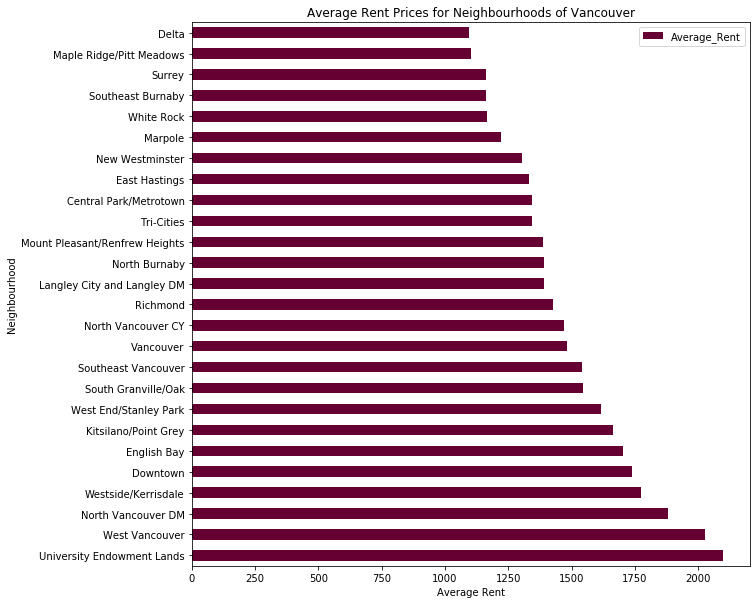

In [91]:
# create bar chart by plotting data from our dataframe
df2 = df[['Neighbourhood','Average_Rent']]
df2.plot(kind='barh', x='Neighbourhood', y='Average_Rent', color='#660033', figsize=(10, 10))

plt.xlabel('Average Rent') # add to x-label to the plot
plt.ylabel('Neighbourhood') # add y-label to the plot
plt.title('Average Rent Prices for Neighbourhoods of Vancouver') # add title to the plot

plt.show()

Next, let's now cluster our neighbourhoods based on average rent prices and see what results we will get. For clustering I will use K-means clustering algortihm, which is very helpful approach of performing unsupervised clustering based on similarities of the input features. In our case the feature is the average rent price of each of the neighbourhoods.

In [141]:
# set number of clusters
kclusters = 7

vanclustering = df2.drop(["Neighbourhood"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(vanclustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 3, 6, 0, 0, 0, 5, 5, 4, 4], dtype=int32)

In [142]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
vanmerged = df2.copy()

# add clustering labels
vanmerged["Cluster Labels"] = kmeans.labels_
vanmerged

,Neighbourhood,Average_Rent,Cluster Labels
0,University Endowment Lands,2097,3
1,West Vancouver,2024,3
2,North Vancouver DM,1881,6
3,Westside/Kerrisdale,1773,0
4,Downtown,1738,0
5,English Bay,1701,0
6,Kitsilano/Point Grey,1662,5
7,West End/Stanley Park,1615,5
8,South Granville/Oak,1545,4
9,Southeast Vancouver,1539,4


From above table we can obviously see that our clustering algorithms has done good job in defining clusters of neighbourhoods based on average rent prices. As we can see most of the clusters comprise of 5-6 neighbourhoods, however there is also a single cluster which has only 3 neighbourhoods, all of which have highest average rent price accordingly. 

Next, let's merge above table back with our original main dataframe and show our clustered neighbourhoods on the Vancouver map to see if there are any visual keys we can obtain from there.

In [143]:
# merge above table with original dataframe to add latitude/longitude for each neighbourhood
df = df[['Neighbourhood', 'Latitude', 'Longitude']]
vanmerged = vanmerged.join(df.set_index("Neighbourhood"), on="Neighbourhood")

print(vanmerged.shape)
vanmerged.head() # check the last columns!

(26, 5)


,Neighbourhood,Average_Rent,Cluster Labels,Latitude,Longitude
0,University Endowment Lands,2097,3,49.258570,-123.220150
1,West Vancouver,2024,3,49.261149,-123.253041
2,North Vancouver DM,1881,6,49.321080,-123.075210
3,Westside/Kerrisdale,1773,0,49.220970,-123.150730
4,Downtown,1738,0,49.281080,-123.115900


Now, let's show our clustered neighbourhoods on the Vancouver map.

In [145]:
vanclusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(vanmerged['Latitude'], vanmerged['Longitude'], vanmerged['Neighbourhood'], vanmerged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(vanclusters)
       
vanclusters

![Alt text](https://raw.githubusercontent.com/bazymbek/Coursera_Capstone/master/price%20clusters.png)

The map above shows some insight on why some clusters of neighbourhoods have higher average rent prices than others. For example, on the map we can see that neighbourhood clusters 3 and 0, representing highest average rent prices are located on the west end of Vancouver City as well as within high-end boroughs such as Downtown Vancouver, English Bay and Richmond.

#### 4. Gather information on venues for each of the neighbourhoods

Let's now proceed with gathering information on venues in each of these neighbourhoods. We will use Foursquare API to obtain this. First, we need to define our Frousqare API credentials.

In [146]:
CLIENT_ID = '5DSAIVMDYYHF3BJNWOWPTNXN0ORTZUT0NGRXZT5HDKPKYB4D'
CLIENT_SECRET = 'WEPP2O4O3RFH5Y0O43GDDXIGW35PH5XCEJXPFH5J4PC51NHE'
VERSION = '20180605' # Foursquare API version

Now let's create a function that would obtain 100 venues within 2000 meters radius in a neighbourhood and store that into the dataframe.

In [147]:
#define the radius and limit variables
radius = 2000
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now let's run the above function on each neighborhood and create a new dataframe called "vanvenues".

In [148]:
vanvenues = getNearbyVenues(names=vanmerged['Neighbourhood'],
                                   latitudes=vanmerged['Latitude'],
                                   longitudes=vanmerged['Longitude']
                                  )

University Endowment Lands
West Vancouver
North Vancouver DM
Westside/Kerrisdale
Downtown
English Bay
Kitsilano/Point Grey
West End/Stanley Park
South Granville/Oak
Southeast Vancouver
Vancouver
North Vancouver CY
Richmond
Langley City and Langley DM
North Burnaby
Mount Pleasant/Renfrew Heights
Tri-Cities
Central Park/Metrotown
East Hastings
New Westminster
Marpole
White Rock
Southeast Burnaby
Surrey
Maple Ridge/Pitt Meadows
Delta


Let's check the size of the resulting dataframe.

In [149]:
print(vanvenues.shape)
vanvenues.head()

(907, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,University Endowment Lands,49.258570,-123.220150,Ranger Station,49.258738,-123.222438,Trail
1,University Endowment Lands,49.258570,-123.220150,"Cleveland Trail, Pacific Spirit Park",49.255623,-123.218226,Trail
2,West Vancouver,49.261149,-123.253041,Beaty Biodiversity Museum,49.263347,-123.251000,Science Museum
3,West Vancouver,49.261149,-123.253041,Mercante,49.263765,-123.255148,Italian Restaurant
4,West Vancouver,49.261149,-123.253041,The Point Grill,49.261740,-123.255626,Sandwich Place


#### 5. Analyze venues in the neighbourhoods by identifying the most common venue categories in each of the neighbourhoods to understand how they differentiate between each other.

First, let's check how many venues were returned for each neighbourhood.

In [150]:
vanvenues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Central Park/Metrotown,45,45,45,45,45,45
Delta,100,100,100,100,100,100
Downtown,100,100,100,100,100,100
East Hastings,26,26,26,26,26,26
English Bay,1,1,1,1,1,1
Kitsilano/Point Grey,34,34,34,34,34,34
Langley City and Langley DM,12,12,12,12,12,12
Maple Ridge/Pitt Meadows,18,18,18,18,18,18
Marpole,16,16,16,16,16,16


Now let's find out how many unique categories there are within all of the returned venues.

In [151]:
print('There are {} unique categories.'.format(len(vanvenues['Venue Category'].unique())))

There are 178 unique categories.


Let's now analyze each neighbourhood for their venue categories and frequency of occurences. First, we will need to do some changes to the dataframe structure.

In [152]:
# one hot encoding
vanonehot = pd.get_dummies(vanvenues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
vanonehot['Neighbourhood'] = vanvenues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [vanonehot.columns[-1]] + list(vanonehot.columns[:-1])
vanonehot = vanonehot[fixed_columns]

vanonehot.head()

,Neighbourhood,American Restaurant,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beach,Beer Bar,Belgian Restaurant,Board Shop,Boat or Ferry,Bookstore,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Fast Food Restaurant,Financial or Legal Service,Food,Food Court,Food Truck,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,Health Food Store,Heliport,Historic Site,History Museum,Hot Dog Joint,Hotel,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Laundromat,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Martial Arts Dojo,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Molecular Gastronomy Restaurant,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Night Market,Noodle House,Office,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Park,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shopping Mall,Skating Rink,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Trade School,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Water Park,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo Exhibit
0,University Endowment Lands,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,University Endowment Lands,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,West Vancouver,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,West Vancouver,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

Next, let's group rows by neighbourhood and by taking the mean of the frequency of occurrence of each category.

In [153]:
vangrouped = vanonehot.groupby('Neighbourhood').mean().reset_index()
vangrouped

,Neighbourhood,American Restaurant,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beach,Beer Bar,Belgian Restaurant,Board Shop,Boat or Ferry,Bookstore,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Fast Food Restaurant,Financial or Legal Service,Food,Food Court,Food Truck,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,Health Food Store,Heliport,Historic Site,History Museum,Hot Dog Joint,Hotel,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Laundromat,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Martial Arts Dojo,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Molecular Gastronomy Restaurant,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Night Market,Noodle House,Office,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Park,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shopping Mall,Skating Rink,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Trade School,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Water Park,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo Exhibit
0,Central Park/Metrotown,0.044444,0.00,0.000000,0.000000,0.022222,0.00,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.044444,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.066667,0.000000,0.066667,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.044444,0.000000,0.00,0.000000,0.000000,0.022222,0.000000,0.000000,0.000000,0.000000,0.00,0.044444,0.000000,0.00,0.00,0.000000,0.022222,0.00,0.000000,0.022222,0.000000,0.000000,0.000000,0.022222,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022222,0.000000,0.044444,0.0000,0.00,0.000000,0.00,0.000000,0.00,0.00,0.044444,0.0000,0.000000,0.000000,0.000000,0.022222,0.022222,0.00,0.000000,0.000000,0.022222,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022222,0.022222,0.000000,0.022222,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.022222,0.000000,0.022222,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.022222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022222,0.000000,0.000000,0.000000,0.000000,0.022222,0.0000,0.022222,0.00,0.000000,0.000000,0.022222,0.000000,0.000000,0.022222,0.022222,0.000000,0.000000,0.000000,0.000000,0.022222,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00

Let's now print each neighbourhood along with its top 5 most common venues.

In [154]:
num_top_venues = 5

for hood in vangrouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = vangrouped[vangrouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Central Park/Metrotown----
               venue  freq
0        Coffee Shop  0.07
1             Bakery  0.07
2     Clothing Store  0.07
3     Cosmetics Shop  0.04
4  Electronics Store  0.04


----Delta----
                venue  freq
0         Coffee Shop  0.07
1                Café  0.05
2               Hotel  0.04
3  Italian Restaurant  0.03
4          Restaurant  0.03


----Downtown----
          venue  freq
0         Hotel  0.10
1   Coffee Shop  0.06
2          Café  0.06
3    Restaurant  0.04
4  Concert Hall  0.03


----East Hastings----
            venue  freq
0     Coffee Shop  0.15
1         Brewery  0.08
2      Restaurant  0.08
3           Diner  0.08
4  Sandwich Place  0.08


----English Bay----
                   venue  freq
0         Sandwich Place   1.0
1    American Restaurant   0.0
2  Performing Arts Venue   0.0
3           Night Market   0.0
4           Noodle House   0.0


----Kitsilano/Point Grey----
              venue  freq
0       Coffee Shop  0.12
1       Pizza

Let's put above information into a dataframe. First,  let's write a function to sort the venues in descending order.

In [155]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [171]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = vangrouped['Neighbourhood']

for ind in np.arange(vangrouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(vangrouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central Park/Metrotown,Bakery,Clothing Store,Coffee Shop,American Restaurant,Hotel,Bookstore,Cosmetics Shop,Gym / Fitness Center,Electronics Store,Movie Theater
1,Delta,Coffee Shop,Café,Hotel,Italian Restaurant,Restaurant,Sandwich Place,Middle Eastern Restaurant,Lounge,Pub,Japanese Restaurant
2,Downtown,Hotel,Coffee Shop,Café,Restaurant,Steakhouse,Concert Hall,Electronics Store,Italian Restaurant,Ramen Restaurant,Bookstore
3,East Hastings,Coffee Shop,Diner,Sandwich Place,Brewery,Park,Restaurant,Deli / Bodega,Pub,Food Truck,Spa
4,English Bay,Sandwich Place,Zoo Exhibit,Ethiopian Restaurant,Food Truck,Food Court,Food,Financial or Legal Service,Fast Food Restaurant,Falafel Restaurant,Exhibit


#### 6. Cluster neighbourhoods based on new venues dataset and visualize clusters on the map.

Now, let's cluster the neighbourhoods. We will again run K-means algorithm to cluster the neighbourhoods into 5 clusters.

In [172]:
# set number of clusters
kclusters = 7

vanclustering2 = vangrouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(vanclustering2)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:26]

array([4, 4, 4, 1, 2, 4, 4, 4, 1, 4, 4, 4, 4, 4, 1, 4, 4, 1, 6, 4, 3, 4,
       1, 5, 0, 4], dtype=int32)

Let's create a new dataframe that includes the cluster labels as well as the top 10 venues for each neighbourhood.

In [173]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

vanmerged2 = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
vanmerged2 = vanmerged2.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

vanmerged2.head() # check the last columns!

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,University Endowment Lands,49.258570,-123.220150,3,Trail,Zoo Exhibit,Ethiopian Restaurant,French Restaurant,Food Truck,Food Court,Food,Financial or Legal Service,Fast Food Restaurant,Falafel Restaurant
1,West Vancouver,49.261149,-123.253041,5,Coffee Shop,Park,Italian Restaurant,Plaza,Fast Food Restaurant,Sandwich Place,Museum,Science Museum,Ethiopian Restaurant,Food
2,North Vancouver DM,49.321080,-123.075210,4,Coffee Shop,Sushi Restaurant,Grocery Store,Middle Eastern Restaurant,Italian Restaurant,Gym / Fitness Center,Sandwich Place,Mediterranean Restaurant,Café,Portuguese Restaurant
3,Westside/Kerrisdale,49.220970,-123.150730,0,Supermarket,Spanish Restaurant,Café,Park,Event Space,Food Truck,Food Court,Food,Financial or Legal Service,Fast Food Restaurant
4,Downtown,49.281080,-123.115900,4,Hotel,Coffee Shop,Café,Restaurant,Steakhouse,Concert Hall,Electronics Store,Italian Restaurant,Ramen Restaurant,Bookstore


Finally, let's visualize our new neighbourhood clusters based on venue categories.

In [196]:
# create map
vanclusters2 = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(vanmerged2['Latitude'], vanmerged2['Longitude'], vanmerged2['Neighbourhood'], vanmerged2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(vanclusters2)

vanclusters2

![Alt text](https://raw.githubusercontent.com/bazymbek/Coursera_Capstone/master/venue%20clusters.png)

#### 7.Analyze if social environment (venues) of the neighbourhoods impact on rent prices, and if yes, then which venue categories specifically have most effect

First, let's examine each cluster and determine the discriminating venue categories that distinguish each cluster.

Cluster 1. We can see that cluster 1 consists of only one neighbourhood, for which the most common venue type is a supermarket. We can also notice that other next most common venue types are diverse and do not specifically tell anything about the cluster.

In [188]:
vanmerged2.loc[vanmerged2['Cluster Labels'] == 0]

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Westside/Kerrisdale,49.22097,-123.15073,0,Supermarket,Spanish Restaurant,Café,Park,Event Space,Food Truck,Food Court,Food,Financial or Legal Service,Fast Food Restaurant


Cluster 2. For Cluster 2 there are also no differentiating venue categories, however, looking at the map above and locating the Cluster 2 neighbourhoods, we can tell that most of them are located in touristic areas with variety of venues and provide a very vibrant lifestyle.

In [189]:
vanmerged2.loc[vanmerged2['Cluster Labels'] == 1]

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,West End/Stanley Park,49.301060,-123.13573,1,Aquarium,Park,Theme Park Ride / Attraction,Zoo Exhibit,Event Space,Pub,Playground,Outdoor Sculpture,Other Great Outdoors,Music Venue
9,Southeast Vancouver,49.270110,-123.11010,1,Coffee Shop,Pet Store,Art Gallery,Sushi Restaurant,Boat or Ferry,Gastropub,Brewery,Italian Restaurant,Café,Liquor Store
12,Richmond,49.303077,-123.03150,1,Bus Station,Fast Food Restaurant,Coffee Shop,Sporting Goods Shop,Gas Station,Gastropub,Music Store,Pastry Shop,French Restaurant,Discount Store
18,East Hastings,49.281163,-123.09076,1,Coffee Shop,Diner,Sandwich Place,Brewery,Park,Restaurant,Deli / Bodega,Pub,Food Truck,Spa
20,Marpole,49.200670,-123.13053,1,Restaurant,Bus Stop,Hotel Pool,Grocery Store,Rental Car Location,Scenic Lookout,Night Market,Shoe Store,Café,Burger Joint


Cluster 3. This is another single-neighbourhood cluster which has food and restaurant venue categories as primary differentiating features.

In [190]:
vanmerged2.loc[vanmerged2['Cluster Labels'] == 2]

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,English Bay,49.132838,-122.859585,2,Sandwich Place,Zoo Exhibit,Ethiopian Restaurant,Food Truck,Food Court,Food,Financial or Legal Service,Fast Food Restaurant,Falafel Restaurant,Exhibit


Cluster 4. A very small cluster which can be differentiated by a very specific venue category - Trail. We can derive that this neighbourhood has a lot of options for those who love spending time in nature.

In [191]:
vanmerged2.loc[vanmerged2['Cluster Labels'] == 3]

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,University Endowment Lands,49.25857,-123.22015,3,Trail,Zoo Exhibit,Ethiopian Restaurant,French Restaurant,Food Truck,Food Court,Food,Financial or Legal Service,Fast Food Restaurant,Falafel Restaurant


Cluster 5. A large cluster with a strong differentiating factor - most common venue categories are coffee shops, bakeries and cafes. Looking at the above map, we also can derive that neighbourhoods of this cluster are located in the heart of Vancouver and provide lots of attractions for its habitants.

In [192]:
vanmerged2.loc[vanmerged2['Cluster Labels'] == 4]

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,North Vancouver DM,49.321080,-123.075210,4,Coffee Shop,Sushi Restaurant,Grocery Store,Middle Eastern Restaurant,Italian Restaurant,Gym / Fitness Center,Sandwich Place,Mediterranean Restaurant,Café,Portuguese Restaurant
4,Downtown,49.281080,-123.115900,4,Hotel,Coffee Shop,Café,Restaurant,Steakhouse,Concert Hall,Electronics Store,Italian Restaurant,Ramen Restaurant,Bookstore
6,Kitsilano/Point Grey,49.268330,-123.165420,4,Coffee Shop,Park,Pizza Place,Café,Sushi Restaurant,Tanning Salon,Diner,Pub,Chinese Restaurant,Restaurant
8,South Granville/Oak,49.260830,-123.141000,4,Coffee Shop,Furniture / Home Store,Japanese Restaurant,Breakfast Spot,American Restaurant,Thai Restaurant,Sushi Restaurant,Electronics Store,Pharmacy,Restaurant
10,Vancouver,49.260380,-123.113360,4,Coffee Shop,Chinese Restaurant,Japanese Restaurant,Pizza Place,Fast Food Restaurant,Ramen Restaurant,Sushi Restaurant,Dessert Shop,Indian Restaurant,Liquor Store
11,North Vancouver CY,49.321080,-123.075210,4,Coffee Shop,Sushi Restaurant,Grocery Store,Middle Eastern Restaurant,Italian Restaurant,Gym / Fitness Center,Sandwich Place,Mediterranean Restaurant,Café,Portuguese Restaurant
13,Langley City and Langley DM,49.113252,-122.657324,4,Breakfast Spot,Sporting Goods Shop,Portuguese Restaurant,Office,Department Store,Furniture / Home Store,Rental Car Location,Pet Store,Martial Arts Dojo,Gym / Fitness Center
14,North Burnaby,49.284611,-123.139880,4,Coffee Shop,Sculpture Garden,Café,Ice Cream Shop,Italian Restaurant,Burger Joint,Spanish Restaurant,Dessert Shop,Sandwich Place,Fast Food Restaurant
15,Mount Pleasant/Renfrew Heights,49.261780,-123.096080,4,Coffee Shop,Diner,Pizza Place,Sushi Restaurant,Sandwich Place,Breakfast Spot,Bar,Thrift / Vintage Store,Lounge,Indian Restaurant
16,Tri-Cities,49.260380,-123.113360,4,Coffee Shop,Chinese Restaurant,Japanese Restaurant,Pizza Place,Fast Food Restaurant,Ramen Restaurant,Sushi Restaurant,Dessert Shop,Indian Restaurant,Liquor Store


Cluster 6. Another small cluster consisting of one neighbourhood with diverse common venues categories that can be found within it.

In [193]:
vanmerged2.loc[vanmerged2['Cluster Labels'] == 5]

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,West Vancouver,49.261149,-123.253041,5,Coffee Shop,Park,Italian Restaurant,Plaza,Fast Food Restaurant,Sandwich Place,Museum,Science Museum,Ethiopian Restaurant,Food


Cluster 7. Last cluster with also one neighbourhood in it. Interestingly, most common venue, which is a music venue, is a very specific and rare venue category in comparison to other clusters. 

In [195]:
vanmerged2.loc[vanmerged2['Cluster Labels'] == 6]

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,Surrey,49.210498,-122.813874,6,Music Venue,Construction & Landscaping,Trail,Zoo Exhibit,Event Space,Food Truck,Food Court,Food,Financial or Legal Service,Fast Food Restaurant


Let's now merge above dataframe and information on average rent prices of the neighbourhoods to see if we can derive any relations between venue categories and rent prices. 

In [197]:
vanmerged = vanmerged[['Neighbourhood', 'Average_Rent']]

vanmerged = vanmerged.join(vanmerged2.set_index('Neighbourhood'), on='Neighbourhood')

vanmerged

,Neighbourhood,Average_Rent,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,University Endowment Lands,2097,49.258570,-123.220150,3,Trail,Zoo Exhibit,Ethiopian Restaurant,French Restaurant,Food Truck,Food Court,Food,Financial or Legal Service,Fast Food Restaurant,Falafel Restaurant
1,West Vancouver,2024,49.261149,-123.253041,5,Coffee Shop,Park,Italian Restaurant,Plaza,Fast Food Restaurant,Sandwich Place,Museum,Science Museum,Ethiopian Restaurant,Food
2,North Vancouver DM,1881,49.321080,-123.075210,4,Coffee Shop,Sushi Restaurant,Grocery Store,Middle Eastern Restaurant,Italian Restaurant,Gym / Fitness Center,Sandwich Place,Mediterranean Restaurant,Café,Portuguese Restaurant
3,Westside/Kerrisdale,1773,49.220970,-123.150730,0,Supermarket,Spanish Restaurant,Café,Park,Event Space,Food Truck,Food Court,Food,Financial or Legal Service,Fast Food Restaurant
4,Downtown,1738,49.281080,-123.115900,4,Hotel,Coffee Shop,Café,Restaurant,Steakhouse,Concert Hall,Electronics Store,Italian Restaurant,Ramen Restaurant,Bookstore
5,English Bay,1701,49.132838,-122.859585,2,Sandwich Place,Zoo Exhibit,Ethiopian Restaurant,Food Truck,Food Court,Food,Financial or Legal Service,Fast Food Restaurant,Falafel Restaurant,Exhibit
6,Kitsilano/Point Grey,1662,49.268330,-123.165420,4,Coffee Shop,Park,Pizza Place,Café,Sushi Restaurant,Tanning Salon,Diner,Pub,Chinese Restaurant,Restaurant
7,West End/Stanley Park,1615,49.301060,-123.135730,1,Aquarium,Park,Theme Park Ride / Attraction,Zoo Exhibit,Event Space,Pub,Playground,Outdoor Sculpture,Other Great Outdoors,Music Venue
8,South Granville/Oak,1545,49.260830,-123.141000,4,Coffee Shop,Furniture / Home Store,Japanese Restaurant,Breakfast Spot,American Restaurant,Thai Restaurant,Sushi Restaurant,Electronics Store,Pharmacy,Restaurant
9,Southeast Vancouver,1539,49.270110,-123.110100,1,Coffee Shop,Pet Store,Art Gallery,Sushi Restaurant,Boat or Ferry,Gastropub,Brewery,Italian Restaurant,Café,Liquor Store


#### Observations

Looking at the above table, it's hard to derive any direct relationships between the frequency of specific venue category in a neighbourhood and the average rent price in that neighbourhood. However, there are some hints showing that there can be relationships between these factors, for example:

* neighbourhoods with parks, trails and other natural venues tend to have higher average rent prices.
* neighbourhoods which have cultural venues such as museums, concert halls, plazas and event spaces tend to rank among high average rent priced neighbourhoods

Nevertheless, we can state that more frequent presence of any specific type of venues does not play a key role in defining rent prices in any of the  neighbourhoods. Actually, looking at the maps we can state that georgraphic location plays a more if not most critical role in defining the rental prices for accomodation. We should also consider presence of key infrastructure, such as public transportation, schools and universities, which provide a comfortable living experience in a given neighbourhood.
